In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib_venn import venn2
from scipy.stats import spearmanr
from sklearn.isotonic import IsotonicRegression

In [6]:
from protein_conformal.util import *
from tqdm import tqdm
import glob
import os

In [7]:
import faiss

In [8]:
scope = np.load('/data/ron/protein-conformal/data/SCOPe_multidomain_embeddings_protein_vec.npy')
print(scope.shape)

# load scope metadata
_, scope_metadata = read_fasta('/data/ron/protein-conformal/data/SCOPe_multidomain.fasta')
print(len(scope_metadata))

(74, 512)
74


In [9]:
afdb = np.load('/data/ron/protein-conformal/data/afdb_embeddings_protein_vec.npy')
# load afdb metadata
_, afdb_metadata = read_fasta('/data/ron/protein-conformal/data/AFDB_sequences.fasta')
print(len(afdb_metadata))
print(afdb.shape)

2302899
(2302899, 512)


In [10]:
# remove > at the beginning of the string for scope metadata and afdb metadata
scope_metadata = [x[1:] for x in scope_metadata if x[0] == '>']
afdb_metadata = [x[1:] for x in afdb_metadata if x[0] == '>']

In [14]:
len(scope_metadata), len(afdb_metadata)

74
2302899


In [8]:
np.save('/data/ron/protein-conformal/data/afdb_metadata.npy', afdb_metadata)
np.save('/data/ron/protein-conformal/data/scope_metadata.npy', scope_metadata)

In [12]:
afdb_lookup = load_database(afdb)

In [15]:
# Query for the 1st nearest neighbor
k = len(afdb_metadata)
D, I = query(afdb_lookup, scope, k)

In [16]:
I.shape, D.shape

((74, 2302899), (74, 2302899))

(array([1.000000e+00, 1.000000e+00, 0.000000e+00, 1.000000e+00,
        1.000000e+00, 4.000000e+00, 2.000000e+00, 6.000000e+00,
        1.300000e+01, 1.100000e+01, 2.300000e+01, 1.900000e+01,
        2.600000e+01, 3.400000e+01, 6.700000e+01, 1.010000e+02,
        1.130000e+02, 1.760000e+02, 2.280000e+02, 3.420000e+02,
        4.420000e+02, 6.230000e+02, 9.720000e+02, 1.217000e+03,
        1.794000e+03, 2.562000e+03, 3.513000e+03, 4.856000e+03,
        6.916000e+03, 9.390000e+03, 1.256200e+04, 1.709600e+04,
        2.277800e+04, 3.022100e+04, 4.050900e+04, 5.273600e+04,
        6.806600e+04, 8.881200e+04, 1.148830e+05, 1.439700e+05,
        1.851180e+05, 2.338420e+05, 2.871250e+05, 3.595320e+05,
        4.377260e+05, 5.418860e+05, 6.558640e+05, 7.803240e+05,
        9.449930e+05, 1.119385e+06, 1.304892e+06, 1.547301e+06,
        1.789326e+06, 2.053846e+06, 2.383457e+06, 2.705845e+06,
        3.038861e+06, 3.441623e+06, 3.865378e+06, 4.225238e+06,
        4.688865e+06, 5.149572e+06, 5.49

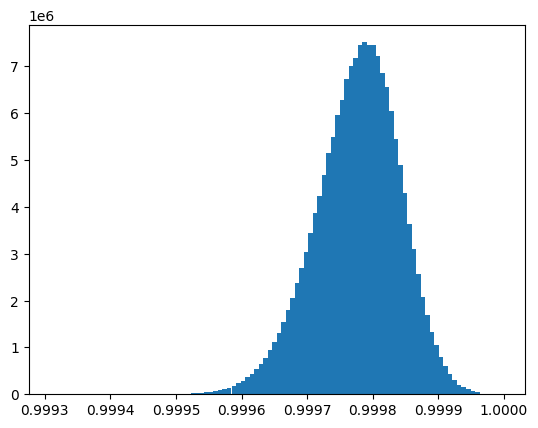

In [11]:
# plot histogram of distances
plt.hist(D.flatten(), bins=100)

## Load DALI results

In [17]:
# load all csvs into a single dataframe from /data/ron/protein-conformal/data/dali_multidomain_results_csv_small
# Get a list of all CSV files in the directory
csv_files = glob.glob('/data/ron/protein-conformal/data/dali_multidomain_results_csv_small/*.csv')

# Read each CSV file into a DataFrame and store all DataFrames in a dictionary where the key is the filename
dfs_dali = {os.path.splitext(os.path.basename(file))[0]: pd.read_csv(file) for file in csv_files}


In [18]:
# sort the dataframes by Z-score
for key in dfs_dali.keys():
    dfs_dali[key] = dfs_dali[key].sort_values(by='Z', ascending=False)

In [19]:
# Concatenate all DataFrames into a single DataFrame
df_dali = pd.concat(dfs_dali.values(), ignore_index=True)

In [20]:
results = []
for i in tqdm(range(I.shape[0])):
    metadata_model = [afdb_metadata[j] for j in I[i]]
    meta_query = scope_metadata[i]
    # get metadata of dali hits
    # metadata_dali = set(dfs_dali[meta_query]['target'].values)
    if meta_query not in dfs_dali:
        continue
    metadata_dali = dfs_dali[meta_query]['target']

    # precompute the DataFrame and create a dictionary for fast lookup
    df = dfs_dali[meta_query]
    z_score_dict = df.set_index('target')['Z'].to_dict()

    # get dali score
    dali_scores = np.zeros_like(metadata_model)
    for j, meta in enumerate(metadata_model):
        dali_scores[j] = z_score_dict.get(meta, 0)
    dali_scores = np.array(dali_scores, dtype=np.float32)

    results.append(({'meta_query': meta_query, 
                     'meta': metadata_model, 
                     'metadata_dali': list(metadata_dali), 
                     'Z_score': dali_scores, 
                     'S_i': D[i]}))

  0%|          | 0/74 [00:00<?, ?it/s]

100%|██████████| 74/74 [07:35<00:00,  6.15s/it]


In [21]:
# np.savez_compressed('/data/ron/protein-conformal/data/dali_results_protein_vec.npz', results)
results = np.load('/data/ron/protein-conformal/data/dali_results_protein_vec.npz', allow_pickle=True)

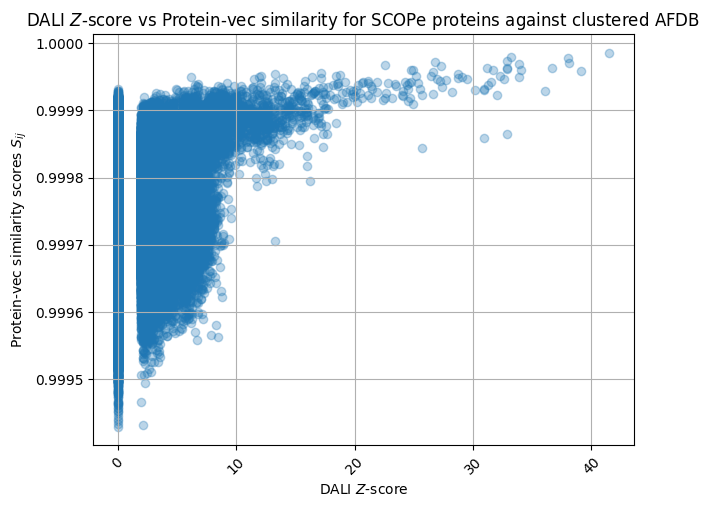

In [61]:
# plt.figure(figsize=(10, 6))
plt.scatter(np.array(results[0]['Z_score']), np.array(results[0]['S_i']), alpha=0.3)
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.xlabel(r'DALI $Z$-score')
plt.ylabel(r'Protein-vec similarity scores $S_{ij}$')
plt.title(r'DALI $Z$-score vs Protein-vec similarity for SCOPe proteins against clustered AFDB')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.4f}'.format(y)))
plt.savefig('/data/ron/protein-conformal/figs/dali_z_score_vs_protein_vec_similarity.pdf', format='pdf', bbox_inches='tight')

# spearman correlation
# print(spearmanr(results[0]['Z_score'], results[0]['S_i']))

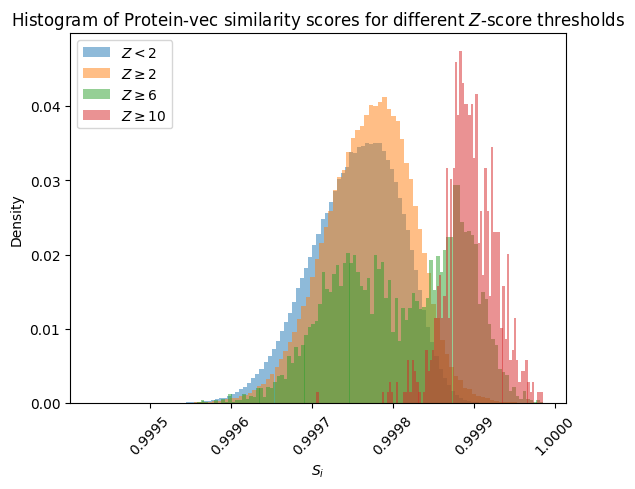

In [57]:
# Extract the first result
result = results[0]

# Ensure both Z_score and S_i are numpy arrays
z_scores = np.array(result['Z_score'])
s_i = np.array(result['S_i'])
# plt.hist(s_i[z_scores ==0], bins=100, color='blue', alpha=0.5, label='z_scores == 0', density=True)
# # plt.hist(s_i[z_scores >2], bins=100, color='red', alpha=0.5, label='z_scores > 2')
# # plt.hist(s_i[z_scores >6], bins=100, color='yellow', alpha=0.5, label='z_scores > 6')
# plt.hist(s_i[z_scores >10], bins=100, color='green', alpha=0.5, label='z_scores > 10', density=True)
weights_0 = np.ones_like(s_i[z_scores ==0]) / len(s_i[z_scores ==0])
plt.hist(s_i[z_scores ==0], bins=100, alpha=0.5, label=r'$Z < 2$', weights=weights_0)

weights_2 = np.ones_like(s_i[z_scores >=2]) / len(s_i[z_scores >=2])
plt.hist(s_i[z_scores >=2], bins=100, alpha=0.5, label=r'$Z \geq 2$', weights=weights_2)

weights_6 = np.ones_like(s_i[z_scores >=6]) / len(s_i[z_scores >=6])
plt.hist(s_i[z_scores >=6], bins=100, alpha=0.5, label=r'$Z \geq 6$', weights=weights_6)
label=r'$S_{ij} \geq \lambda$'

weights_10 = np.ones_like(s_i[z_scores >= 10]) / len(s_i[z_scores >=10])
plt.hist(s_i[z_scores >=10], bins=100, alpha=0.5, label=r'$Z \geq 10$', weights=weights_10)
# plt.yscale('log')
plt.legend()
plt.xticks(rotation=45)
plt.xlabel(r'$S_i$')
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.4f}'.format(y)))
plt.ylabel('Density')
plt.title(r'Histogram of Protein-vec similarity scores for different $Z$-score thresholds')
plt.savefig('/data/ron/protein-conformal/figs/dali_histogram_2.pdf', format='pdf', bbox_inches='tight')

In [ ]:
print(np.mean(s_i[z_scores ==0]))
print(np.mean(s_i[z_scores >0]))

0.9997545
0.99977


In [32]:
spearman_corr, p_value = spearmanr(z_scores[(z_scores != 0)], s_i[(z_scores != 0)])

In [33]:
spearman_corr, p_value

(0.006870736577610317, 0.00431871619366604)

In [30]:
def find_curve_change_point(x, y):
    """
    Finds the point of maximum curvature in the given data.

    Parameters:
    x (array-like): The x-coordinates of the data points.
    y (array-like): The y-coordinates of the data points.

    Returns:
    int: The index of the point of maximum curvature.
    """

    # Compute first and second derivatives
    first_derivative = np.gradient(y, x)
    second_derivative = np.gradient(first_derivative, x)

    # Find the index of the maximum second derivative
    curve_change_index = np.argmax(np.abs(second_derivative))

    return curve_change_index

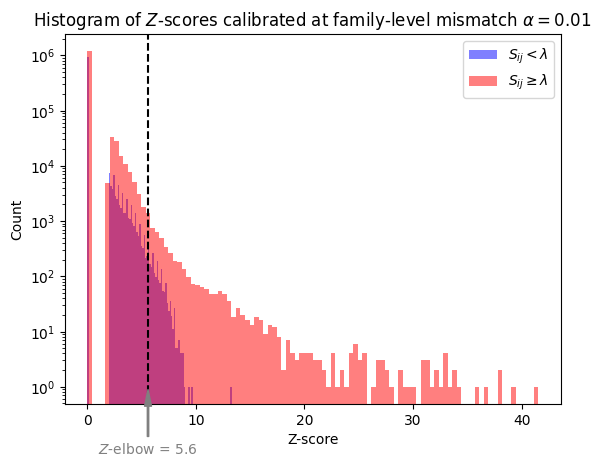

In [70]:
# lam = 0.9996087811008182

# lams = [0.99967641, 0.99983299, 0.99974871]
lam = 0.99974871
elbow_z = 5.6
plt.figure()
plt.hist(z_scores[s_i < lam], bins=100, color='blue', alpha=0.5, label=r'$S_{ij} < \lambda$')
plt.hist(z_scores[s_i >= lam], bins=100, color='red', alpha=0.5, label=r'$S_{ij} \geq \lambda$')
# plt.hist(z_scores[np.logical_and(s_i < lam, z_scores > elbow_z)], bins=100, color='blue', alpha=0.5, label='s_i < lam')
# plt.hist(z_scores[np.logical_and(s_i > lam, z_scores > elbow_z)], bins=100, color='red', alpha=0.5, label='s_i > lam')
# make a line at the elbow_z
plt.axvline(elbow_z, color='black', linestyle='--')
# Annotate the vertical line
plt.annotate(
    rf'$Z$-elbow = {elbow_z}', 
    xy=(elbow_z, 1), 
    xytext=(elbow_z, 0.1), 
    arrowprops=dict(facecolor='gray', edgecolor='gray', shrink=0.05, width=1, headwidth=5), 
    fontsize=10,
    color='gray',
    horizontalalignment='center', 
    # verticalalignment='bottom'
    verticalalignment='top'
)
plt.xlabel('Z-score')
plt.ylabel('Count')
plt.yscale('log')
# plt.title(rf'Histogram of $Z$-scores for different Protein-vec similarity threshold $\lambda = {lam}$')
plt.title(rf'Histogram of $Z$-scores calibrated at family-level mismatch $\alpha = {.01}$')
plt.savefig('/data/ron/protein-conformal/figs/histogram_z_at_thresh_new_title.pdf', format='pdf')
# plt.title(rf'Histogram of Z-scores for different Protein-vec similarity threshold $\lambda = ${lambda}')
plt.legend()

In [53]:
# y can be predefined through z_scores > elbow_z or 0, so I think we can use the same functions as before

total_samples_above_2 = len(z_scores[(z_scores > 0)])
print(total_samples_above_2)
total_samples_above_elbow = len(z_scores[(z_scores > elbow_z)])
print(total_samples_above_elbow)
missed_samples_above_elbow = z_scores[(z_scores > elbow_z) & (s_i < lam)]
print(len(missed_samples_above_elbow))
found_samples_above_elbow = z_scores[(z_scores > elbow_z) & (s_i >= lam)]
print(len(found_samples_above_elbow))
missed_samples_above_2 = z_scores[(z_scores > 0) & (s_i < lam)]
print(len(missed_samples_above_2))
found_samples_above_2 = z_scores[(z_scores > 0) & (s_i >= lam)]
print(len(found_samples_above_2))
total_samples_lambda = len(z_scores[(s_i >= lam)])
print(total_samples_lambda)
# missed_samples = samples_above_elbow[s_i[samples_above_elbow > 0] < lam]

172530
6167
1807
4360
57430
115100
1323286


In [ ]:
# output the fraction of the set that has a z-score above 2


In [34]:
n_calib = 10
cal_data = results[:n_calib]
test_data = results[n_calib:2*n_calib]
# X_cal, y_cal = np.array([np.array(x['S_i'][x['Z_score'] > 0]) for x in cal_data]), np.array([np.array(x['Z_score'][x['Z_score'] > 0]) for x in cal_data])
# X_test, y_test = np.array([np.array(x['S_i'][x['Z_score'] > 0]) for x in test_data]), np.array([np.array(x['Z_score'][x['Z_score'] > 0]) for x in test_data])

X_cal, y_cal = np.array([x['S_i'] for x in cal_data]), np.array([x['Z_score'] for x in cal_data])
X_test, y_test = np.array([x['S_i'] for x in test_data]), np.array([x['Z_score'] for x in test_data])
#filter out zeros in all data (Z_score)
# X_cal = np.array([x[x != 0] for x in X_cal])
# y_test = np.array([y[y != 0] for y in y_test])

# fit isotonic regression
ir = IsotonicRegression()
ir.fit(X_cal.flatten(), y_cal.flatten())
# y_cal_iso = ir.predict(X_cal.flatten())
# y_test_iso = ir.predict(X_test.flatten())

IsotonicRegression()

In [50]:
def find_elbow_point(x, y):
    """
    Finds the elbow point in the given data.

    Parameters:
    x (array-like): The x-coordinates of the data points.
    y (array-like): The y-coordinates of the data points.

    Returns:
    int: The index of the elbow point.
    """

    # Calculate the slope of the line connecting the first and last points
    line_vector = np.array([x[-1] - x[0], y[-1] - y[0]])
    line_vector = line_vector / np.linalg.norm(line_vector)

    # Project each point onto the line
    projection = np.dot(np.vstack((x - x[0], y - y[0])).T, line_vector)
    projection = np.outer(projection, line_vector)
    proj_x = x[0] + projection[:, 0]
    proj_y = y[0] + projection[:, 1]

    # Calculate the distance from each point to the line
    distances = np.sqrt((x - proj_x) ** 2 + (y - proj_y) ** 2)

    # Find the index of the maximum distance
    elbow_index = np.argmax(distances)

    return elbow_index

In [64]:
def maximum_separation(dist_lst, first_grad, use_max_grad):
    opt = 0 if first_grad else -1
    gamma = np.append(dist_lst[1:], np.repeat(dist_lst[-1], 10))
    sep_lst = np.abs(dist_lst - np.mean(gamma))
    sep_grad = np.abs(sep_lst[:-1]-sep_lst[1:])
    if use_max_grad:
        # max separation index determined by largest grad
        max_sep_i = np.argmax(sep_grad)
    else:
        # max separation index determined by first or the last grad
        large_grads = np.where(sep_grad > np.mean(sep_grad))
        max_sep_i = large_grads[-1][opt]
    # if no large grad is found, just call first EC
    if max_sep_i >= 5:
        max_sep_i = 0
    return max_sep_i

In [66]:
maximum_separation(np.sort(z_scores), True, False)

0

In [53]:
len([x for x in range(len(z_scores))])

2302899

In [70]:
find_curve_change_point(np.array([x for x in range(len(z_scores))]), np.sort(z_scores)[::-1])

1

In [75]:
z_scores

array([41.5, 33.2, 38. , ...,  0. ,  2.1,  0. ], dtype=float32)

In [76]:
find_elbow_point(np.array([x for x in range(np.sum([z_scores > 0]))]) , np.sort(z_scores[z_scores>0])[::-1])

6167

In [77]:
np.sort(z_scores)[::-1][6167]

5.6

In [68]:
np.sort(z_scores)[::-1][172230:172830]

array([2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2.

In [1]:
np.sort(z_scores[::-1])[172530]

NameError: name 'np' is not defined

In [59]:
z_scores[-95]

0.0

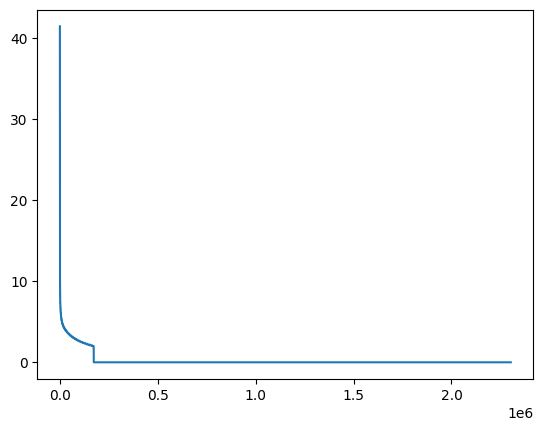

In [63]:
plt.plot(np.sort(z_scores)[::-1])

In [35]:
x_test_iso = np.linspace(np.min(X_test), np.max(X_test), 1000)
phats = ir.predict(x_test_iso)

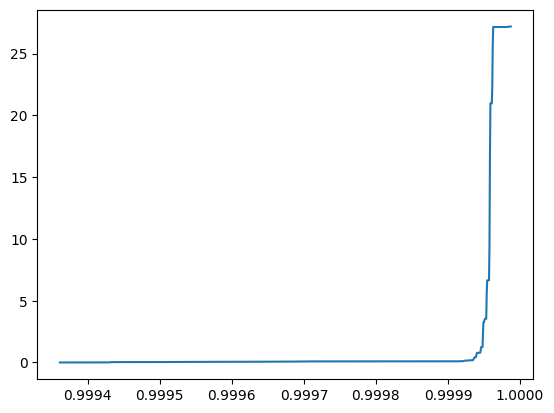

In [36]:
plt.plot(x_test_iso, phats, label='Isotonic Regression')

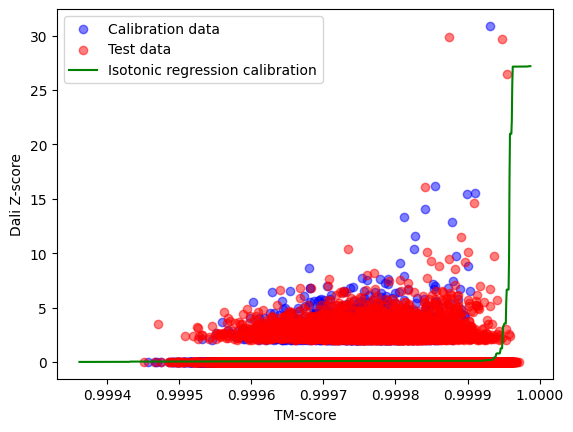

In [37]:
# plot isotonic regression results
# plt.figure(figsize=(10, 10))
# grab 10000 random samples for plotting

idx = np.random.choice(X_cal.flatten().shape[0], 100000)
# X_cal, y_cal = X_cal[idx], y_cal[idx]
# idx = np.random.choice(X_test.shape[0], 10000)
# X_test, y_test = X_test[idx], y_test[idx]
# y_cal_iso = y_cal_iso[idx]
# y_test_iso = y_test_iso[idx]

plt.scatter(X_cal.flatten()[idx], y_cal.flatten()[idx], color='blue', alpha=.5, label='Calibration data')
plt.scatter(X_test.flatten()[idx], y_test.flatten()[idx], color='red', alpha=.5, label='Test data')
# plt.scatter(X_cal.flatten()[idx], y_cal_iso[idx], color='blue', alpha=.5, label='Isotonic regression calibration', marker='s', s=50)
# plt.scatter(X_test.flatten()[idx], y_test_iso[idx], color='red', alpha=.5, label='Isotonic regression test', marker='s', s=50)
# plt.plot(X_cal.flatten()[idx], y_cal_iso[idx], color='blue', label='Isotonic regression calibration')
plt.plot(x_test_iso, phats, color='green', label='Isotonic regression calibration')
# plt.plot(X_test.flatten()[idx], y_test_iso[idx], color='red', label='Isotonic regression test')

# plt.scatter(X_cal.flatten()[idx], y_cal.flatten()[idx], color='blue', alpha=.5, label='Calibration data')
# plt.scatter(X_test.flatten()[idx], y_test.flatten()[idx], color='red', alpha=.5, label='Test data')
# plt.scatter(X_cal.flatten()[idx], y_cal_iso[idx], color='blue', alpha=.5, label='Isotonic regression calibration')
# plt.scatter(X_test.flatten()[idx], y_test_iso[idx], color='red', alpha=.5, label='Isotonic regression test')


plt.xlabel('TM-score')
plt.ylabel('Dali Z-score')
plt.legend()
plt.show()


In [ ]:
plt.hist([x['S_i'][0] for x in results], bins=100)

In [ ]:
# load DALI results

In [32]:
dali_1oisA = pd.read_csv('/data/ron/protein-conformal/data/dali_multidomain_results_csv/1oisA.csv')

In [36]:
dali_1oisA.head()

,query,target,Z,RMSD,Alignment_Length,Hit_Length,Query_Length,Perc_Ident,Query_Cov_Perc,Full_Alignment,Alphafold_link
0,1ois,A0A7J2Z1R5,3.1,15.8,93,160,1000,9,9.3,NaN,https://alphafold.ebi.ac.uk/entry/A0A7J2Z1R5
1,1ois,A0A7H4LGP6,2.3,5.3,69,102,1000,12,6.9,NaN,https://alphafold.ebi.ac.uk/entry/A0A7H4LGP6
2,1ois,F0ZDL3,3.3,18.4,98,499,1000,7,9.8,NaN,https://alphafold.ebi.ac.uk/entry/F0ZDL3
3,1ois,V9IJC9,18.7,1.5,187,685,1000,41,18.7,NaN,https://alphafold.ebi.ac.uk/entry/V9IJC9
4,1ois,A0A0D3D5Z1,2.3,21.2,82,351,1000,5,8.2,NaN,https://alphafold.ebi.ac.uk/entry/A0A0D3D5Z1


In [37]:
len(dali_1oisA)

47

In [38]:
scope_metadata[0]

'>2hhvA'

In [41]:
'>1oisA' in scope_metadata
# get location of 1oisA in scope
scope_idx = [i for i, x in enumerate(scope_metadata) if '>1oisA' in x][0]

In [42]:
scope_idx

22

In [68]:
scope_metadata[0]

'2hhvA'

In [69]:
afdb_metadata[0]

'A0A009E921'

In [50]:
dali_1oisA['target'][0] in afdb_metadata

True

In [70]:
dali_test = pd.read_csv('/data/ron/protein-conformal/data/dali_multidomain_results_csv/2hhvA.csv')

In [71]:
dali_test.head()

,query,target,Z,RMSD,Alignment_Length,Hit_Length,Query_Length,Perc_Ident,Query_Cov_Perc,Full_Alignment,Alphafold_link
0,2hhv,A0A496M0L2,6.7,3.0,114,142,1000,10,11.4,\nDSSP llllleelllllhhhhlLEEEEEEELLL---------l...,https://alphafold.ebi.ac.uk/entry/A0A496M0L2
1,2hhv,A0A3M7BNU4,6.3,3.9,127,267,1000,11,12.7,\nDSSP ------------------------llllleelllllhh...,https://alphafold.ebi.ac.uk/entry/A0A3M7BNU4
2,2hhv,B4U6R4,6.0,3.2,107,196,1000,8,10.7,\nDSSP llllleelllllhhhhlleeeeeeelllllllllllle...,https://alphafold.ebi.ac.uk/entry/B4U6R4
3,2hhv,A0A535HFQ5,5.9,7.3,74,146,1000,14,7.4,\nDSSP llllleelllllhhhhlleeeeeeelllllllllllle...,https://alphafold.ebi.ac.uk/entry/A0A535HFQ5
4,2hhv,A0A3M0L026,5.4,7.8,119,293,1000,11,11.9,\nDSSP ---------LLLLLeelllllhhhhlleeeeeeellll...,https://alphafold.ebi.ac.uk/entry/A0A3M0L026


In [72]:
len(dali_test)

172531

In [58]:
metadata_test = afdb_metadata[I[0]]


TypeError: only integer scalar arrays can be converted to a scalar index

In [86]:
# index into afdb metadata with I[0]
metadata_test = [afdb_metadata[i] for i in I[0]]
print(len(metadata_test))

In [90]:
# sort dali_test by Z score
dali_test_sorted = dali_test.sort_values('Z', ascending=False)

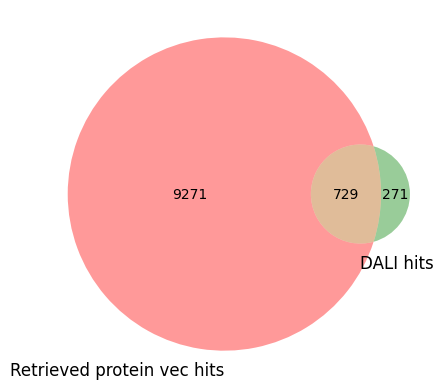

In [96]:
# look at top 1000 DALI hits vs top 10000 retrieved protein vec hits
venn2([set(metadata_test[0:10000]), set(dali_test_sorted[0:1000]['target'])], ('Retrieved protein vec hits', 'DALI hits'))

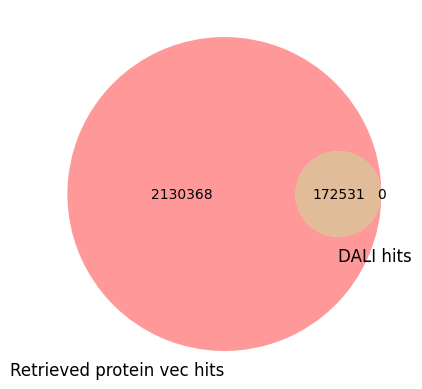

In [87]:
# make venn diagram of the intersection of the DALI results and the nearest neighbors, which would be metadata_test and dali_test['target']
venn2([set(metadata_test), set(dali_test['target'])], ('Retrieved protein vec hits', 'DALI hits'))
# set(dali_test[dali_test['Z'] > 10]['target'])


In [77]:
dali_test['Z'].describe()

count    172531.000000
mean          3.134578
std           1.322030
min           2.000000
25%           2.300000
50%           2.800000
75%           3.600000
max          41.500000
Name: Z, dtype: float64

In [98]:
# Create a dictionary where the keys are the elements of afdb_metadata and the values are their indices
afdb_metadata_dict = {value: index for index, value in enumerate(afdb_metadata)}

# Now use this dictionary to find the indices of the elements in dali_test['target']
metadata_test_target = [afdb_metadata_dict[x] for x in dali_test['target'] if x in afdb_metadata_dict]

In [102]:
lookup_dict_test = {value: index for index, value in enumerate(I[0])}

In [103]:
# dali_faiss_intersection = [lookup_dict_test[x] for x in metadata_test_target if x in lookup_dict_test]
dali_faiss_idcs = [lookup_dict_test[x] for x in metadata_test_target]

In [113]:
# KL divergence between the two distributions D[0][dali_faiss_idcs] and D[0]
from scipy.stats import entropy

# Ensure the distributions are normalized to represent probabilities
# dist1 = D[0][dali_faiss_idcs] / np.sum(D[0][dali_faiss_idcs])
# dist2 = D[0] / np.sum(D[0])

# # Calculate the KL divergence
# kl_divergence = entropy(dist1, dist2)

# Create a new array of zeros with the same shape as D[0]
full_dist1 = np.zeros_like(D[0])

# Place the values of D[0][dali_faiss_idcs] at the corresponding indices in the new array
full_dist1[dali_faiss_idcs] = D[0][dali_faiss_idcs]

# Now full_dist1 and D[0] have the same shape, and you can compute the KL divergence as before
dist1 = full_dist1 / np.sum(full_dist1)
dist2 = D[0] / np.sum(D[0])

kl_divergence = entropy(dist1, dist2)

In [115]:
print(np.mean(D[0][dali_faiss_idcs]), np.mean(D[0]))
print(np.std(D[0][dali_faiss_idcs]), np.std(D[0]))
print(np.min(D[0][dali_faiss_idcs]), np.min(D[0]))
print(np.max(D[0][dali_faiss_idcs]), np.max(D[0]))
print(np.median(D[0][dali_faiss_idcs]), np.median(D[0]))


0.9997702 0.99975544
5.3681983e-05 5.4961118e-05
0.99943256 0.9994294
0.9999858 0.9999858
0.9997734 0.9997598


Text(0.5, 1.0, 'protein-vec distance distribution of DALI hits vs all hits')

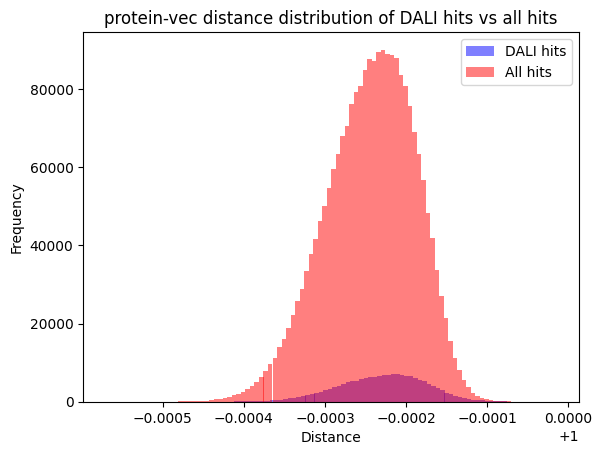

In [106]:
plt.hist(D[0][dali_faiss_idcs], bins=100, alpha=0.5, label='DALI hits', color='blue')
plt.hist(D[0], bins=100, alpha=0.5, label='All hits', color='red')
plt.legend()
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.title('protein-vec distance distribution of DALI hits vs all hits')

In [97]:
# index into afdb metadata with dali_test['target']
metadata_test_target = [afdb_metadata.index(x) for x in dali_test['target']]

KeyboardInterrupt: 

In [64]:
afdb_metadata.index(dali_test['target'][0])

1107878